In [1]:
import os
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from torch.distributions.categorical import Categorical
from datetime import datetime


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
from collections import deque

class RollingAverage:
    def __init__(self, window_size):
        self.window = deque(maxlen=window_size)
        self.averages = []

    def update(self, value):
        self.window.append(value)
        self.averages.append(self.get_average)

    @property
    def get_average(self):
        return sum(self.window) / len(self.window) if self.window else 0.0

## REINFORCE

In [ ]:
class PolicyGradient(nn.Module):
    
    def __init__(
        self,
        environ: gym.Env, 
        input_shape: int, 
        game_name: str, 
        hidden_layers: list = [64],
        gamma: float = 0.99,
        device: str = 'cpu',
        learning_rate: float = 0.01,
        max_grad: float = 1.5, 
        *args,
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        
        self._agent_name = 'REINFORCE'
        self.device = device
        self.input_shape = input_shape
        self.env = environ
        self.gamma = gamma
        self.game_name = game_name
        self.max_grad = max_grad
        
        self.layers = nn.Sequential(
            nn.Linear(input_shape, hidden_layers[0]), 
            nn.ReLU()
        )
        
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            self.layers.append(nn.ReLU())
            
        self.layers.append(nn.Linear(hidden_layers[-1], environ.action_space.n))
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
    
    def forward(
        self, 
        x: torch.tensor
    ) -> torch.tensor:
        x = x.flatten(start_dim=1) if len(x.shape) > 1 else x.flatten()
        return self.layers(x)
    
    def select_action(
        self, 
        state: np.ndarray
    ) -> np.int64:
        state = torch.as_tensor(state, dtype=torch.float32, device=self.device)
        with torch.no_grad():
            action_logits = self(state)
        
        distribution = Categorical(logits=action_logits)
        action = distribution.sample()
        return int(action.item())
    
    def get_return(
        self, 
        rewards: list,
    ) -> float:
        G = 0
        returns = []
        for reward in reversed(rewards):
            G = reward + self.gamma * G
            returns.insert(0, G)  
        return returns

    
    def get_action_probs(
        self, 
        states: torch.tensor,
        actions: torch.tensor
    ) -> torch.tensor:
        logits = self(states)
        distribution = Categorical(logits=logits)
        return distribution.log_prob(actions)
    
    def update_step(
        self, 
        states: list,
        actions: list,
        returns: list
    ) -> None:
        
        states_torch = torch.as_tensor(np.array(states), dtype=torch.float32, device=self.device).view(-1, self.input_shape)
        actions_torch = torch.as_tensor(actions, dtype=torch.int64, device=self.device).view(-1, 1)
        returns_torch = torch.as_tensor(np.array(returns), dtype=torch.float32, device=self.device).view(-1, 1)
        
        action_probs = self.get_action_probs(states_torch, actions_torch)
        loss = -(action_probs * returns_torch).sum()
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=self.max_grad)
        self.optimizer.step()
        
    def train(
        self,
        num_eps: int = 200,
        save=False
    ) -> list:
        average_rewards = RollingAverage(20)
        buffer = {'states': [], 'actions': [], 'rewards' : []}
        
        def update_buffer(state, action, reward):
            buffer['states'].append(state)
            buffer['actions'].append(action)
            buffer['rewards'].append(reward)
        
        def reset_buffer():
            return {'states': [], 'actions': [], 'rewards' : []}
        
        for step in range(num_eps):
            obs, _ = self.env.reset()
            done = False
            while not done:
                action = self.select_action(obs)
                obs_prime, reward, terminated, truncated, _ = self.env.step(action)     
                update_buffer(obs, action, reward)
                
                obs = obs_prime
                done = terminated or truncated
        
            average_rewards.update(float(np.sum(buffer['rewards'])))
            print(f'Episode: {step+1} | Avg Reward: {average_rewards.get_average:.4f}', end='\r')
            
            returns = self.get_return(buffer['rewards'])
            
            self.update_step(buffer['states'], buffer['actions'], returns)
            
            buffer = reset_buffer()
        
        if save:
            torch.save(self.state_dict(), f'models/{self._agent_name}_{self.game_name.upper()}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}')
        
        return average_rewards

In [ ]:
env = gym.make('CartPole-v1')
policy_cartpole = PolicyGradient(env, 4, 'cartpole', hidden_layers=[256], learning_rate=0.001, device=device).to(device)

avg_rewards = policy_cartpole.train(num_eps=500, save=True)

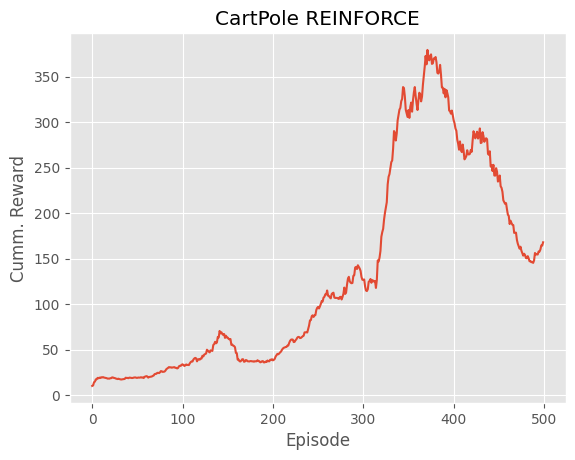

In [205]:
plt.style.use('ggplot')
plt.plot(range(len(avg_rewards.averages)), avg_rewards.averages, label='Average Reward')
plt.xlabel('Episode')
plt.ylabel('Cumm. Reward')
plt.title('CartPole REINFORCE');

## Q Actor Critic

In [ ]:
class QActorCritic(nn.Module):
    
    def __init__(
        self, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)